In [ ]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import Model
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
drive.mount('/content/drive')
zip_file_path = '/content/drive/MyDrive/Datasets/kidney_refined_img'
csv_file_path = '/content/drive/MyDrive/Datasets/Coldsheet.csv'

Mounted at /content/drive


In [ ]:
scores_df = pd.read_csv(csv_file_path)
scores_df.head()

Name of image  Score of 1 - 5
0  Cold Kidney 2               5
1  Cold Kidney 3               5
2  Cold Kidney 4               5
3  Cold Kidney 5               5
4  Cold Kidney 6               4

In [ ]:
def load_and_preprocess_image(image_path):
    try:
        if os.path.isfile(image_path):
            img = load_img(image_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
    return None

In [ ]:
image_dir = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, filename))]
image_arrays = [load_and_preprocess_image(path) for path in image_paths if load_and_preprocess_image(path) is not None]
image_arrays = np.vstack([img_array for img_array in image_arrays if img_array is not None])
def format_filename(name):
    return os.path.splitext(name)[0].lower().strip()

scores_df['formatted_name'] = scores_df['Name of image'].apply(format_filename)
name_to_score = dict(zip(scores_df['formatted_name'], scores_df['Score of 1 - 5']))

In [ ]:
scores = []
not_found = []

for path in image_paths:
    if os.path.isfile(path):
        base_name = format_filename(os.path.basename(path))
        score = name_to_score.get(base_name, None)
        if score is not None:
            scores.append(score)
        else:
            not_found.append(os.path.basename(path))
            scores.append(-1)

if not_found:
    print("No scores found for the following files:")
    for file in not_found:
        print(file)
else:
    print("All files matched successfully.")

All files matched successfully.


In [ ]:
scores = np.array(scores)
valid_indices = [i for i, score in enumerate(scores) if score != -1]
image_arrays = image_arrays[valid_indices]
scores = np.array([scores[i] for i in valid_indices])
scores = scores - 1  # Subtract 1 from each score to shift from 1-5 to 0-4

#**VGG19**

In [ ]:
# Load the VGG19 model, pre-trained weights, exclude the top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')  # assuming score 1-5, hence 5 classes
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_images, val_images, train_scores, val_scores = train_test_split(image_arrays, scores, test_size=0.2, random_state=42)

In [ ]:
model.fit(train_images, train_scores, epochs=10, validation_data=(val_images, val_scores))

Epoch 1/10
3/3 [==============================] - 84s 28s/step - loss: 20.6335 - accuracy: 0.2250 - val_loss: 15.7793 - val_accuracy: 0.5500
Epoch 2/10
3/3 [==============================] - 82s 29s/step - loss: 3.3242 - accuracy: 0.7125 - val_loss: 19.4106 - val_accuracy: 0.3000
Epoch 3/10
3/3 [==============================] - 81s 30s/step - loss: 1.3336 - accuracy: 0.8500 - val_loss: 20.2360 - val_accuracy: 0.3000
Epoch 4/10
3/3 [==============================] - 90s 30s/step - loss: 0.4767 - accuracy: 0.9125 - val_loss: 19.0807 - val_accuracy: 0.3500
Epoch 5/10
3/3 [==============================] - 76s 27s/step - loss: 0.2244 - accuracy: 0.9875 - val_loss: 18.1811 - val_accuracy: 0.3500
Epoch 6/10
3/3 [==============================] - 76s 27s/step - loss: 0.0740 - accuracy: 0.9750 - val_loss: 17.2987 - val_accuracy: 0.4500
Epoch 7/10
3/3 [==============================] - 77s 28s/step - loss: 0.1301 - accuracy: 0.9625 - val_loss: 16.2884 - val_accuracy: 0.4500
Epoch 8/10
3/3 [===

In [ ]:
val_loss, val_acc = model.evaluate(val_images, val_scores)
print(f"Validation accuracy: {val_acc*100:.2f}%")

1/1 [==============================] - 15s 15s/step - loss: 16.1251 - accuracy: 0.4500
Validation accuracy: 45.00%


In [ ]:
model_path = "/content/drive/MyDrive/Others Work/vgg19"
model.save(model_path)

In [ ]:
np.save('/content/drive/MyDrive/Others Work/vgg19/X_train.npy', train_images)
np.save('/content/drive/MyDrive/Others Work/vgg19/X_test.npy', val_images)
np.save('/content/drive/MyDrive/Others Work/vgg19/y_train_one_hot.npy', train_scores)
np.save('/content/drive/MyDrive/Others Work/vgg19/y_test_one_hot.npy', val_scores)

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 vgg19
1 flatten
2 dense
3 dropout
4 dense_1


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Load the base VGG19 model without the top layer
base_model = VGG19(weights='imagenet', include_top=False)

# Define the layers from which you want to extract features
layer_names = ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']
layer_outputs = [base_model.get_layer(name).output for name in layer_names]
multi_output_model = Model(inputs=base_model.input, outputs=layer_outputs)

def extract_features(image_tensor):
    # Ensure the image tensor is in the right format
    image_tensor = preprocess_input(image_tensor)
    # Expand the dimensions of the image tensor to include batch size
    image_tensor = np.expand_dims(image_tensor, axis=0)
    try:
        return multi_output_model.predict(image_tensor)
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

features_by_layer = [[] for _ in range(len(layer_names))]

for image_array in image_arrays:
    if image_array.ndim == 3:
        image_array = np.expand_dims(image_array, axis=0)

    if image_array.ndim != 4:
        print(f"Skipping an image due to unexpected dimensions: {image_array.shape}")
        continue

    # Extract features for all layers
    features_per_layer = extract_features(image_array[0])
    if features_per_layer is None:
        continue

    # Flatten and collect features separately for each layer
    for i, features in enumerate(features_per_layer):
        layer_name = layer_names[i]
        feature_shape = features.shape
        print(f"Layer {layer_name}: Feature shape {feature_shape}")

        flattened_features = features.reshape(-1)  # Flatten the features
        features_by_layer[i].append(flattened_features)

# Save the features to disk
for i, layer_features in enumerate(features_by_layer):
    features_array = np.vstack(layer_features)
    save_path = f'/content/drive/MyDrive/Others Work/vgg19/kidney_features_layer_{i}.npy'
    np.save(save_path, features_array)
    print(f"Features for layer {layer_names[i]} saved to {save_path}")


1/1 [==============================] - 1s 809ms/step
Layer block1_pool: Feature shape (1, 112, 112, 64)
Layer block2_pool: Feature shape (1, 56, 56, 128)
Layer block3_pool: Feature shape (1, 28, 28, 256)
Layer block4_pool: Feature shape (1, 14, 14, 512)
Layer block5_pool: Feature shape (1, 7, 7, 512)
1/1 [==============================] - 1s 647ms/step
Layer block1_pool: Feature shape (1, 112, 112, 64)
Layer block2_pool: Feature shape (1, 56, 56, 128)
Layer block3_pool: Feature shape (1, 28, 28, 256)
Layer block4_pool: Feature shape (1, 14, 14, 512)
Layer block5_pool: Feature shape (1, 7, 7, 512)
1/1 [==============================] - 1s 618ms/step
Layer block1_pool: Feature shape (1, 112, 112, 64)
Layer block2_pool: Feature shape (1, 56, 56, 128)
Layer block3_pool: Feature shape (1, 28, 28, 256)
Layer block4_pool: Feature shape (1, 14, 14, 512)
Layer block5_pool: Feature shape (1, 7, 7, 512)
1/1 [==============================] - 1s 612ms/step
Layer block1_pool: Feature shape (1, 112,

In [ ]:
features_array.shape

(100, 25088)

In [ ]:
# Function to format the filename
def format_filename(name):
    return os.path.splitext(name)[0].lower().strip()

# Use the features extracted from the last layer
features = features_by_layer[-1]

# 'image_paths' contains the paths for each image corresponding to each feature row in 'features'
# 'name_to_score' is a dictionary mapping filenames to scores

# Match scores with features
matched_scores = []
feature_list = []
not_found = []

for i, path in enumerate(image_paths):
    if os.path.isfile(path):
        base_name = format_filename(os.path.basename(path))
        score = name_to_score.get(base_name, None)
        if score is not None:
            matched_scores.append(score)
            feature_list.append(features[i])
        else:
            not_found.append(os.path.basename(path))

# Reporting files with no corresponding scores
if not_found:
    print("No scores found for the following files:")
    for file in not_found:
        print(file)
else:
    print("All files matched successfully.")

# Convert lists to numpy arrays for subsequent machine learning processing
matched_scores = np.array(matched_scores)
feature_array = np.vstack(feature_list)

All files matched successfully.


In [ ]:
X_train = np.load('/content/drive/MyDrive/Others Work/vgg19/X_train.npy')
X_test = np.load('/content/drive/MyDrive/Others Work/vgg19/X_test.npy')
y_train_one_hot = np.load('/content/drive/MyDrive/Others Work/vgg19/y_train_one_hot.npy')
y_test_one_hot = np.load('/content/drive/MyDrive/Others Work/vgg19/y_test_one_hot.npy')

In [ ]:
predictions = model.predict(X_test)
predicted_scores = np.argmax(predictions, axis=1) + 1

1/1 [==============================] - 16s 16s/step


In [ ]:
predicted_scores

array([1, 1, 1, 3, 1, 4, 3, 1, 4, 3, 2, 1, 1, 2, 3, 2, 1, 1, 3, 1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_array, matched_scores, test_size=0.2, random_state=42)

# Initialize and train the classifier
classifier = LogisticRegression(max_iter=1000)  # Increasing max_iter for convergence if necessary
classifier.fit(X_train, y_train)

# Predict and evaluate the classifier
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.50


#**LogisticRegression**

In [ ]:
def train_and_evaluate(features, scores, layer_name):
    X_train, X_test, y_train, y_test = train_test_split(features, scores, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    classifier = LogisticRegression(max_iter=1000, class_weight='balanced')
    classifier.fit(X_train_scaled, y_train)

    predictions = classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)

    print(f"Accuracy for {layer_name}: {accuracy:.2f}")
    print(classification_report(y_test, predictions))


In [ ]:
# 'scores' contains the matched target scores for each image
for i, layer_features in enumerate(features_by_layer):
    layer_name = layer_names[i]  # Assuming 'layer_names' list exists
    layer_features_array = np.vstack(layer_features)
    train_and_evaluate(layer_features_array, scores, layer_name)

Accuracy for block1_pool: 0.35
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       0.50      0.14      0.22         7
           4       0.00      0.00      0.00         0

    accuracy                           0.35        20
   macro avg       0.22      0.20      0.19        20
weighted avg       0.39      0.35      0.32        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Accuracy for block2_pool: 0.35
              precision    recall  f1-score   support

           0       0.44      0.57      0.50         7
           1       1.00      0.50      0.67         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7

    accuracy                           0.35        20
   macro avg       0.44      0.30      0.34        20
weighted avg       0.47      0.35      0.38        20

Accuracy for block3_pool: 0.40
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7
           4       0.00      0.00      0.00         0

    accuracy                           0.40        20
   macro avg       0.39      0.25      0.26        20
weighted avg       0.53      0.40      0.40        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for block4_pool: 0.25
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.00      0.00      0.00         4
           2       0.09      0.50      0.15         2
           3       0.50      0.14      0.22         7

    accuracy                           0.25        20
   macro avg       0.30      0.27      0.22        20
weighted avg       0.39      0.25      0.27        20

Accuracy for block5_pool: 0.45
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.00      0.00      0.00         4
           2       0.14      0.50      0.22         2
           3       1.00      0.29      0.44         7
           4       0.00      0.00      0.00         0

    accuracy                           0.45        20
   macro avg       0.36      0.33      0.28        20
weighted avg       0.60      0.45      0.44        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**SVM**

In [ ]:
from sklearn.svm import SVC

def train_and_evaluate_svm(features, scores, layer_name):
    X_train, X_test, y_train, y_test = train_test_split(features, scores, test_size=0.2, random_state=42)

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    classifier = SVC(kernel='linear', C=1)
    classifier.fit(X_train_scaled, y_train)

    predictions = classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)

    print(f"Accuracy for {layer_name}: {accuracy:.2f}")
    print(classification_report(y_test, predictions))

In [ ]:
# 'scores' contains the matched target scores for each image
for i, layer_features in enumerate(features_by_layer):
    layer_name = layer_names[i]  # 'layer_names' list exists
    layer_features_array = np.vstack(layer_features)
    train_and_evaluate(layer_features_array, scores, layer_name)

Accuracy for block1_pool: 0.35
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       0.50      0.14      0.22         7
           4       0.00      0.00      0.00         0

    accuracy                           0.35        20
   macro avg       0.22      0.20      0.19        20
weighted avg       0.39      0.35      0.32        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Accuracy for block2_pool: 0.35
              precision    recall  f1-score   support

           0       0.44      0.57      0.50         7
           1       1.00      0.50      0.67         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7

    accuracy                           0.35        20
   macro avg       0.44      0.30      0.34        20
weighted avg       0.47      0.35      0.38        20

Accuracy for block3_pool: 0.40
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7
           4       0.00      0.00      0.00         0

    accuracy                           0.40        20
   macro avg       0.39      0.25      0.26        20
weighted avg       0.53      0.40      0.40        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for block4_pool: 0.25
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.00      0.00      0.00         4
           2       0.09      0.50      0.15         2
           3       0.50      0.14      0.22         7

    accuracy                           0.25        20
   macro avg       0.30      0.27      0.22        20
weighted avg       0.39      0.25      0.27        20

Accuracy for block5_pool: 0.45
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.00      0.00      0.00         4
           2       0.14      0.50      0.22         2
           3       1.00      0.29      0.44         7
           4       0.00      0.00      0.00         0

    accuracy                           0.45        20
   macro avg       0.36      0.33      0.28        20
weighted avg       0.60      0.45      0.44        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def train_and_evaluate_rf(features, scores, layer_name):
    X_train, X_test, y_train, y_test = train_test_split(features, scores, test_size=0.2, random_state=42)

    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)

    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    print(f"Accuracy for {layer_name}: {accuracy:.2f}")
    print(classification_report(y_test, predictions))

In [ ]:
# 'scores' contains the matched target scores for each image
for i, layer_features in enumerate(features_by_layer):
    layer_name = layer_names[i]  # 'layer_names' list exists
    layer_features_array = np.vstack(layer_features)
    train_and_evaluate(layer_features_array, scores, layer_name)

Accuracy for block1_pool: 0.35
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       0.50      0.14      0.22         7
           4       0.00      0.00      0.00         0

    accuracy                           0.35        20
   macro avg       0.22      0.20      0.19        20
weighted avg       0.39      0.35      0.32        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Accuracy for block2_pool: 0.35
              precision    recall  f1-score   support

           0       0.44      0.57      0.50         7
           1       1.00      0.50      0.67         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7

    accuracy                           0.35        20
   macro avg       0.44      0.30      0.34        20
weighted avg       0.47      0.35      0.38        20

Accuracy for block3_pool: 0.40
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7
           4       0.00      0.00      0.00         0

    accuracy                           0.40        20
   macro avg       0.39      0.25      0.26        20
weighted avg       0.53      0.40      0.40        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for block4_pool: 0.25
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.00      0.00      0.00         4
           2       0.09      0.50      0.15         2
           3       0.50      0.14      0.22         7

    accuracy                           0.25        20
   macro avg       0.30      0.27      0.22        20
weighted avg       0.39      0.25      0.27        20

Accuracy for block5_pool: 0.45
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.00      0.00      0.00         4
           2       0.14      0.50      0.22         2
           3       1.00      0.29      0.44         7
           4       0.00      0.00      0.00         0

    accuracy                           0.45        20
   macro avg       0.36      0.33      0.28        20
weighted avg       0.60      0.45      0.44        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**GradientBoostingClassifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def train_and_evaluate_gbm(features, scores, layer_name):
    X_train, X_test, y_train, y_test = train_test_split(features, scores, test_size=0.2, random_state=42)

    classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    classifier.fit(X_train, y_train)

    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    print(f"Accuracy for {layer_name}: {accuracy:.2f}")
    print(classification_report(y_test, predictions))

In [ ]:
# 'scores' contains the matched target scores for each image
for i, layer_features in enumerate(features_by_layer):
    layer_name = layer_names[i]  # 'layer_names' list exists
    layer_features_array = np.vstack(layer_features)
    train_and_evaluate(layer_features_array, scores, layer_name)

Accuracy for block1_pool: 0.35
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       0.50      0.14      0.22         7
           4       0.00      0.00      0.00         0

    accuracy                           0.35        20
   macro avg       0.22      0.20      0.19        20
weighted avg       0.39      0.35      0.32        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Accuracy for block2_pool: 0.35
              precision    recall  f1-score   support

           0       0.44      0.57      0.50         7
           1       1.00      0.50      0.67         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7

    accuracy                           0.35        20
   macro avg       0.44      0.30      0.34        20
weighted avg       0.47      0.35      0.38        20

Accuracy for block3_pool: 0.40
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7
           4       0.00      0.00      0.00         0

    accuracy                           0.40        20
   macro avg       0.39      0.25      0.26        20
weighted avg       0.53      0.40      0.40        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for block4_pool: 0.25
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.00      0.00      0.00         4
           2       0.09      0.50      0.15         2
           3       0.50      0.14      0.22         7

    accuracy                           0.25        20
   macro avg       0.30      0.27      0.22        20
weighted avg       0.39      0.25      0.27        20

Accuracy for block5_pool: 0.45
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.00      0.00      0.00         4
           2       0.14      0.50      0.22         2
           3       1.00      0.29      0.44         7
           4       0.00      0.00      0.00         0

    accuracy                           0.45        20
   macro avg       0.36      0.33      0.28        20
weighted avg       0.60      0.45      0.44        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**Neural Networks**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def train_and_evaluate_nn(features, scores, layer_name):
    X_train, X_test, y_train, y_test = train_test_split(features, scores, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f"Accuracy for {layer_name}: {accuracy:.2f}")


In [ ]:
# 'scores' contains the matched target scores for each image
for i, layer_features in enumerate(features_by_layer):
    layer_name = layer_names[i]  # 'layer_names' list exists
    layer_features_array = np.vstack(layer_features)
    train_and_evaluate(layer_features_array, scores, layer_name)

Accuracy for block1_pool: 0.35
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       0.50      0.14      0.22         7
           4       0.00      0.00      0.00         0

    accuracy                           0.35        20
   macro avg       0.22      0.20      0.19        20
weighted avg       0.39      0.35      0.32        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Accuracy for block2_pool: 0.35
              precision    recall  f1-score   support

           0       0.44      0.57      0.50         7
           1       1.00      0.50      0.67         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7

    accuracy                           0.35        20
   macro avg       0.44      0.30      0.34        20
weighted avg       0.47      0.35      0.38        20

Accuracy for block3_pool: 0.40
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         2
           3       0.33      0.14      0.20         7
           4       0.00      0.00      0.00         0

    accuracy                           0.40        20
   macro avg       0.39      0.25      0.26        20
weighted avg       0.53      0.40      0.40        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for block4_pool: 0.25
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.00      0.00      0.00         4
           2       0.09      0.50      0.15         2
           3       0.50      0.14      0.22         7

    accuracy                           0.25        20
   macro avg       0.30      0.27      0.22        20
weighted avg       0.39      0.25      0.27        20

Accuracy for block5_pool: 0.45
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.00      0.00      0.00         4
           2       0.14      0.50      0.22         2
           3       1.00      0.29      0.44         7
           4       0.00      0.00      0.00         0

    accuracy                           0.45        20
   macro avg       0.36      0.33      0.28        20
weighted avg       0.60      0.45      0.44        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**Layers Output**

block1

1/1 [==============================] - 0s 130ms/step


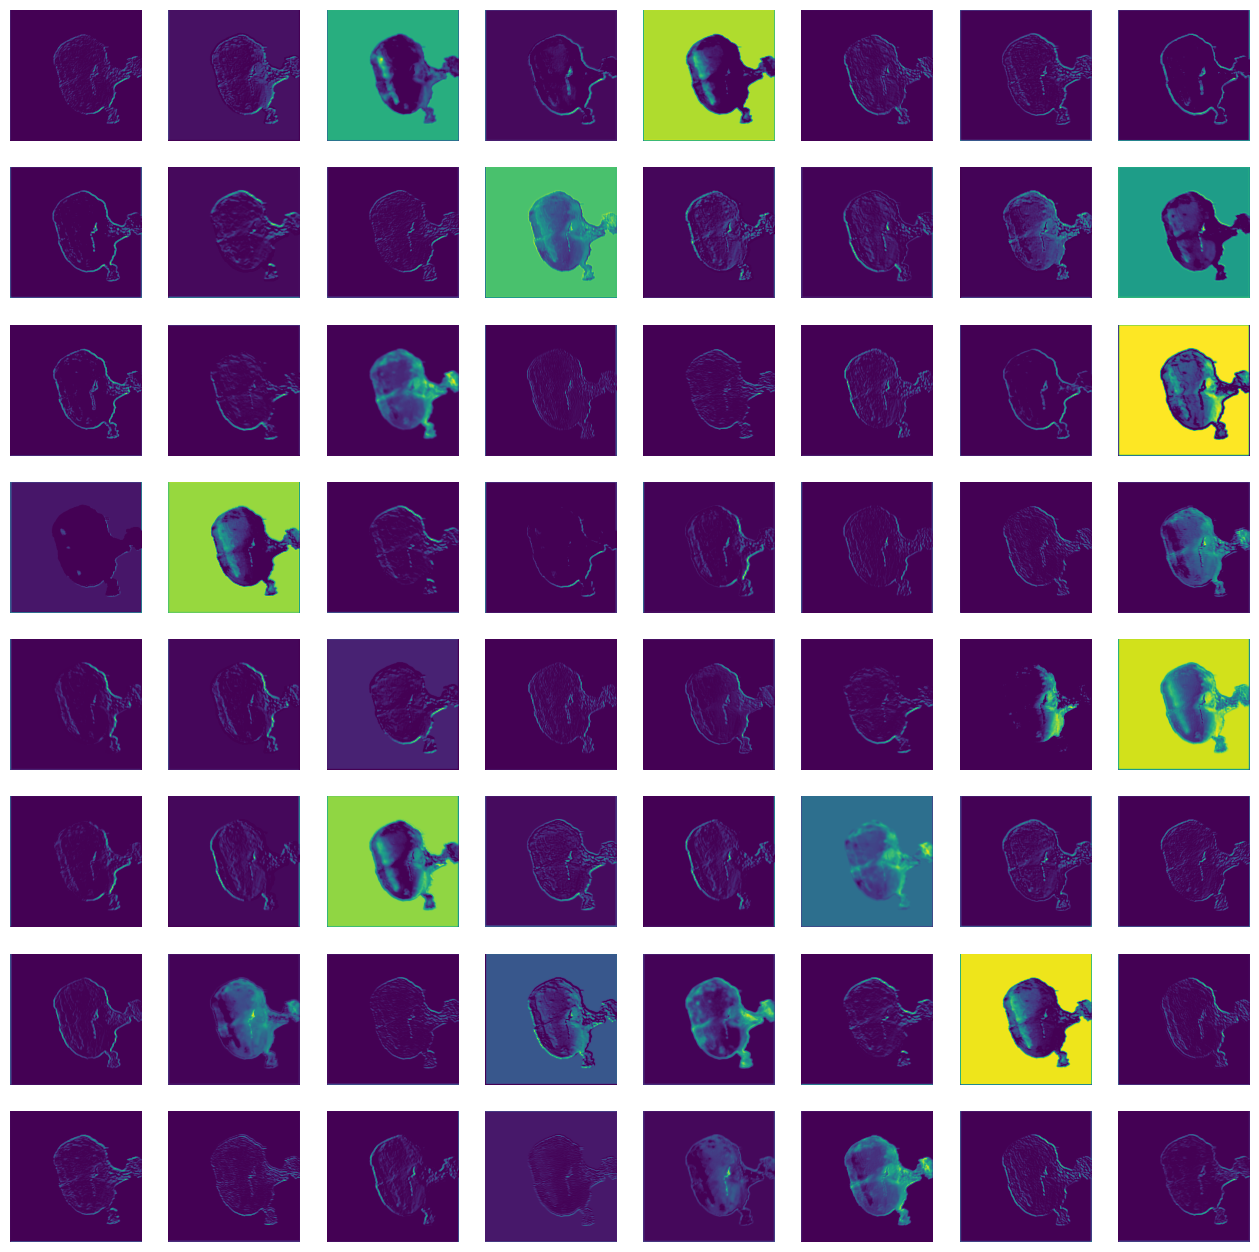

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block1_conv2'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 204ms/step


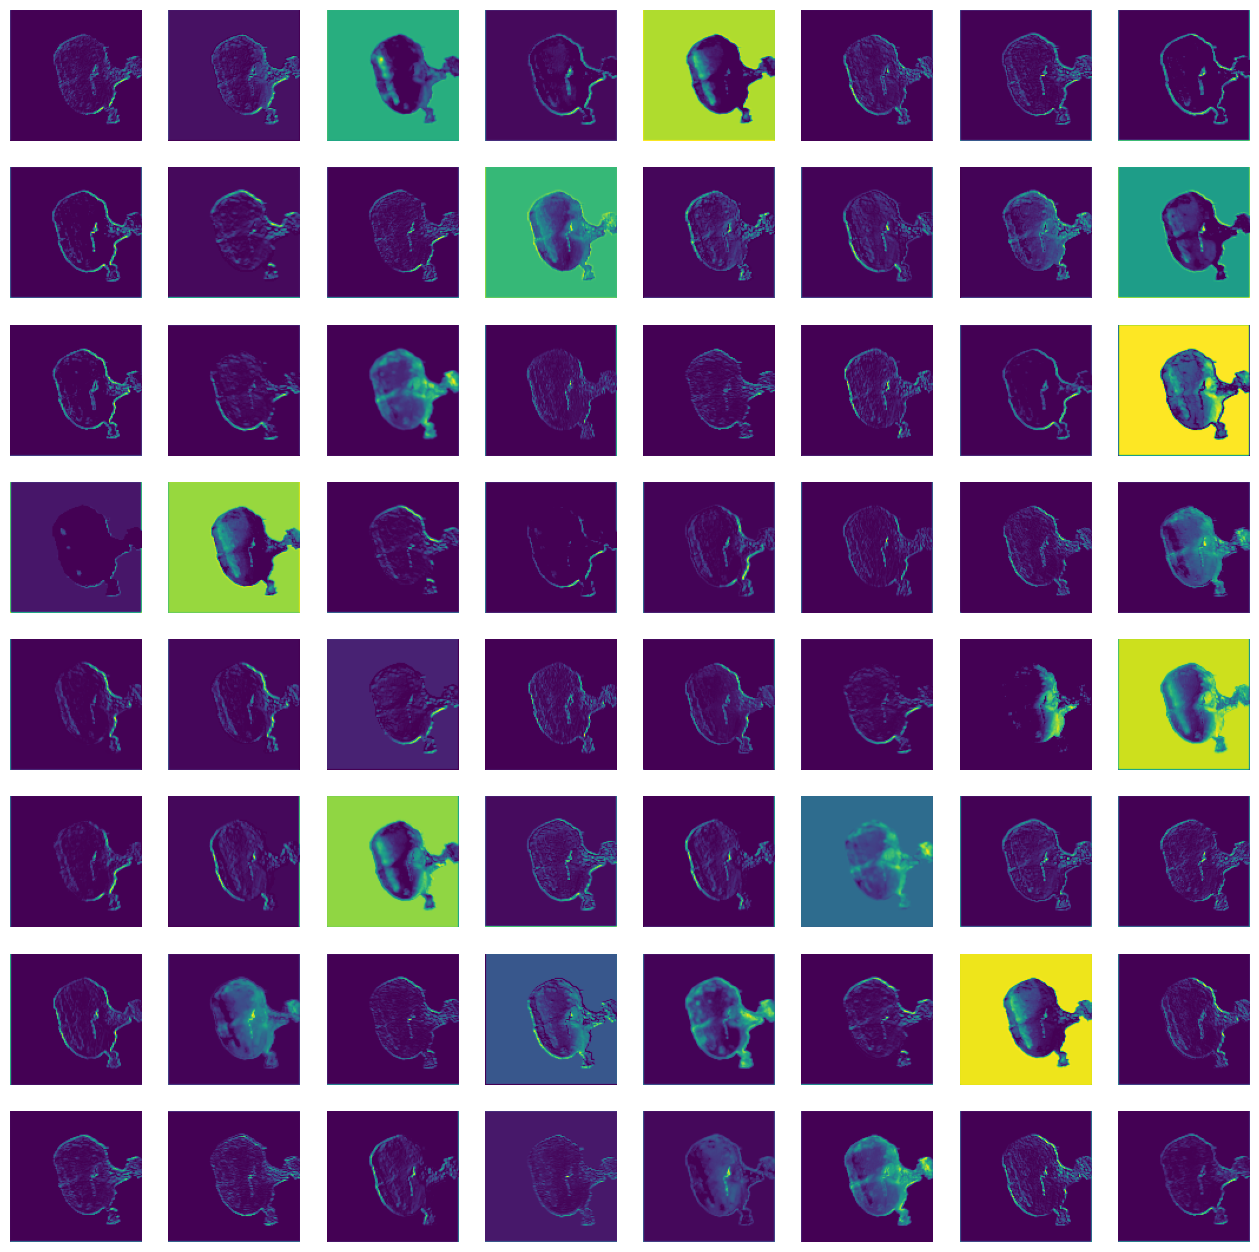

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block1_pool'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

block2

1/1 [==============================] - 0s 359ms/step


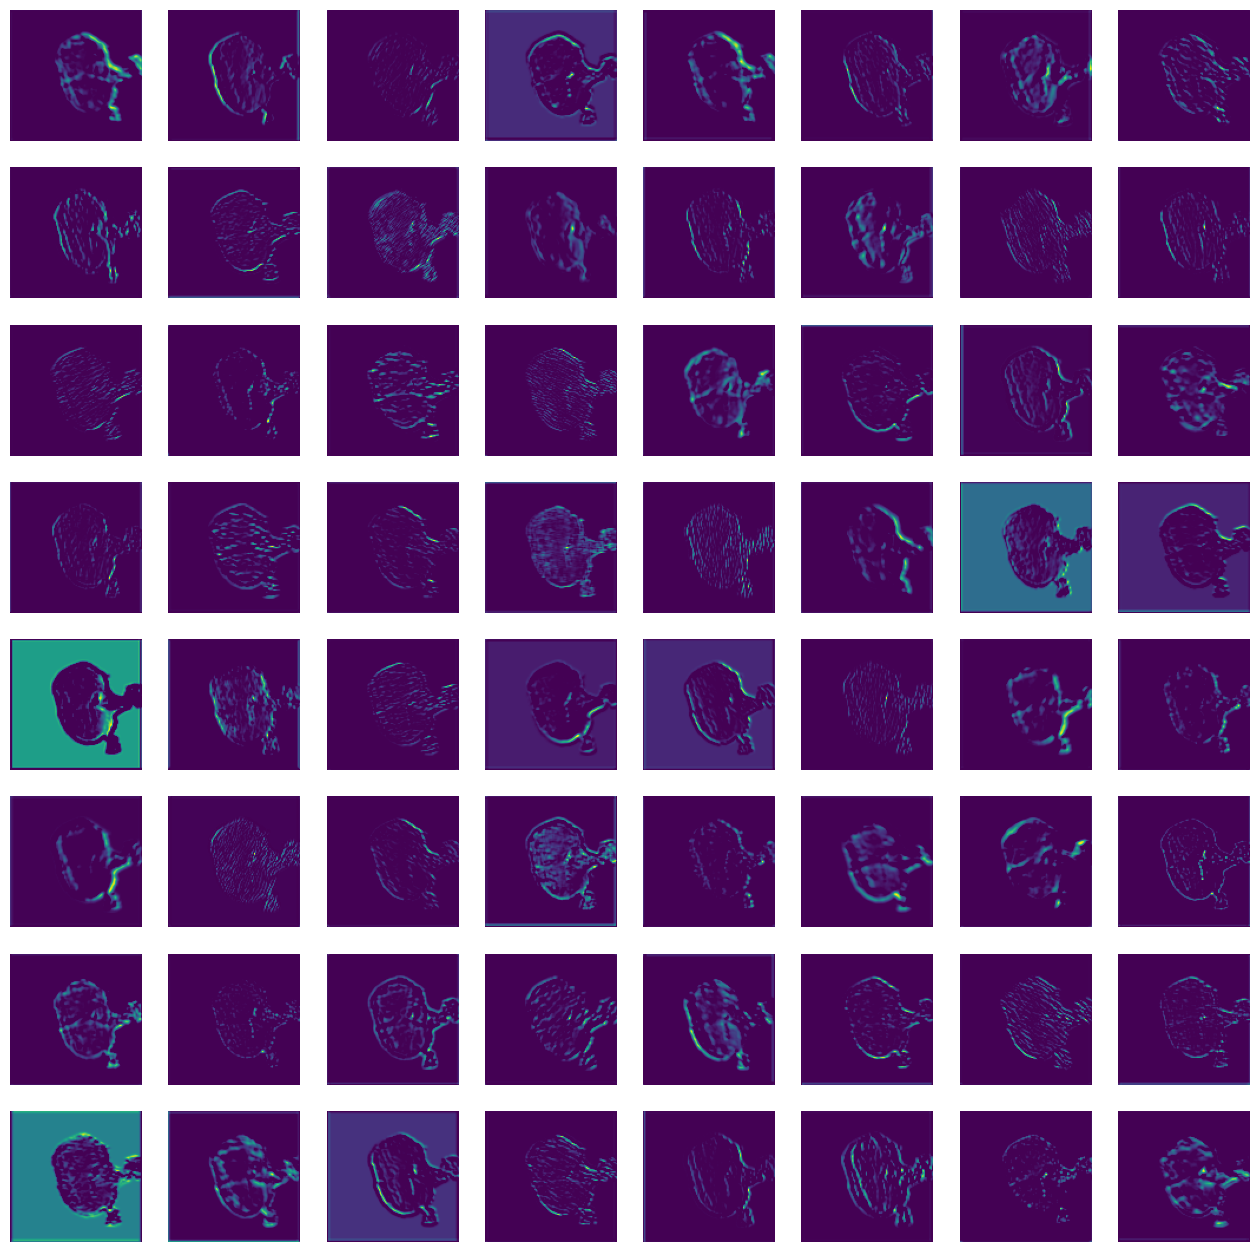

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block2_conv2'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

1/1 [==============================] - 1s 639ms/step


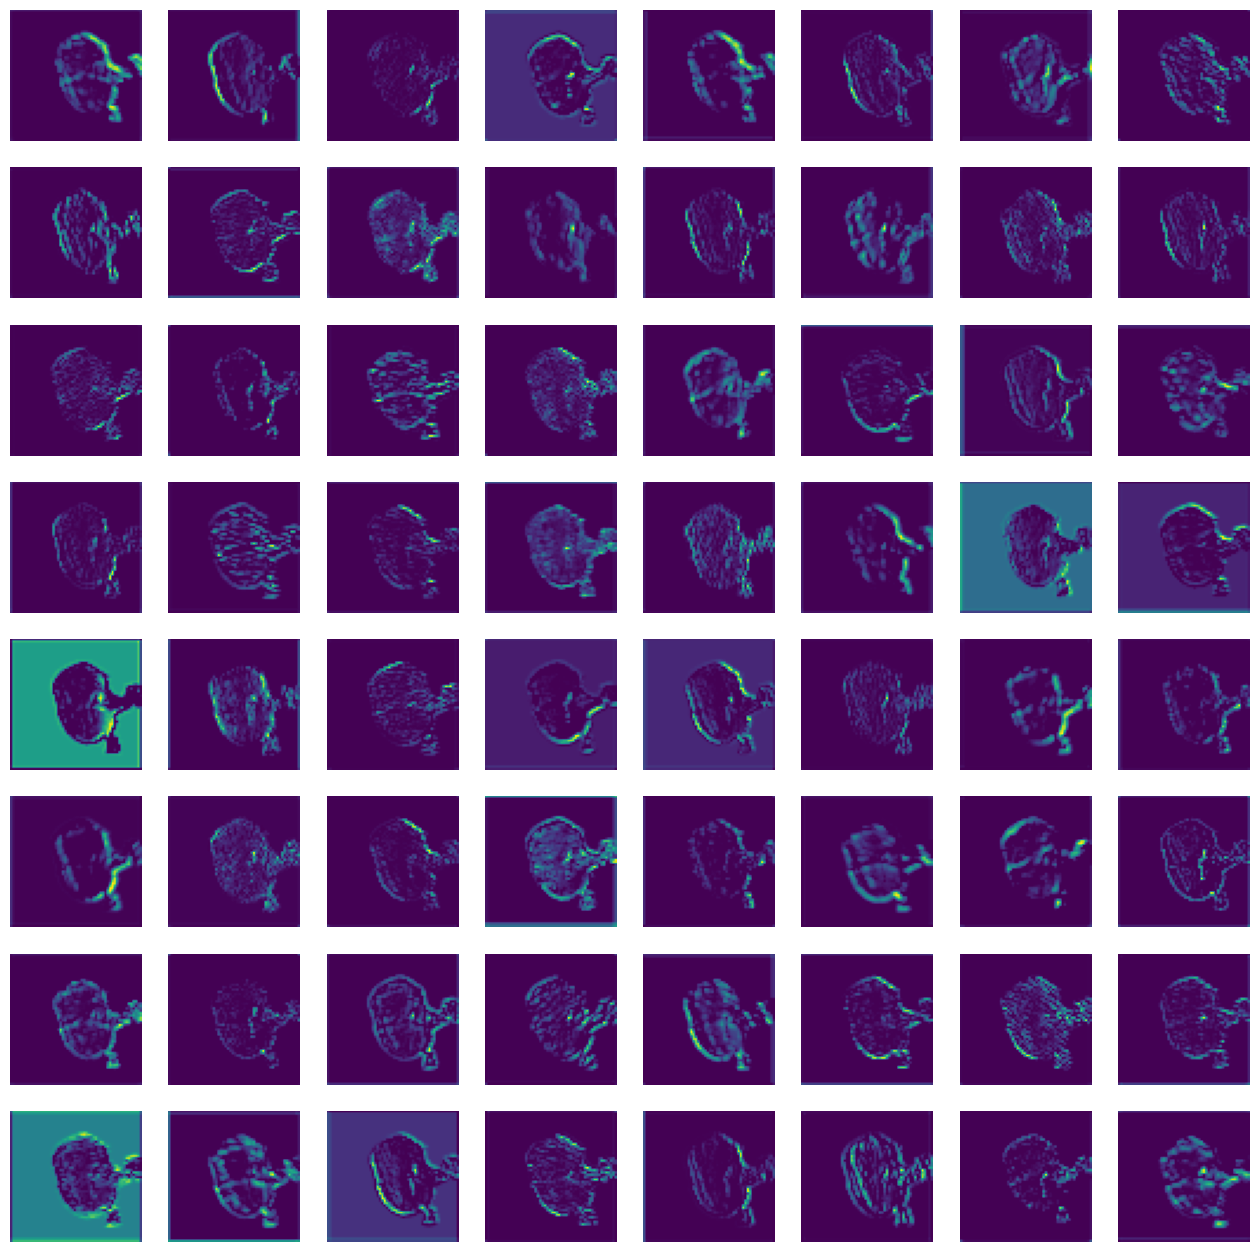

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block2_pool'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

block3

1/1 [==============================] - 0s 360ms/step


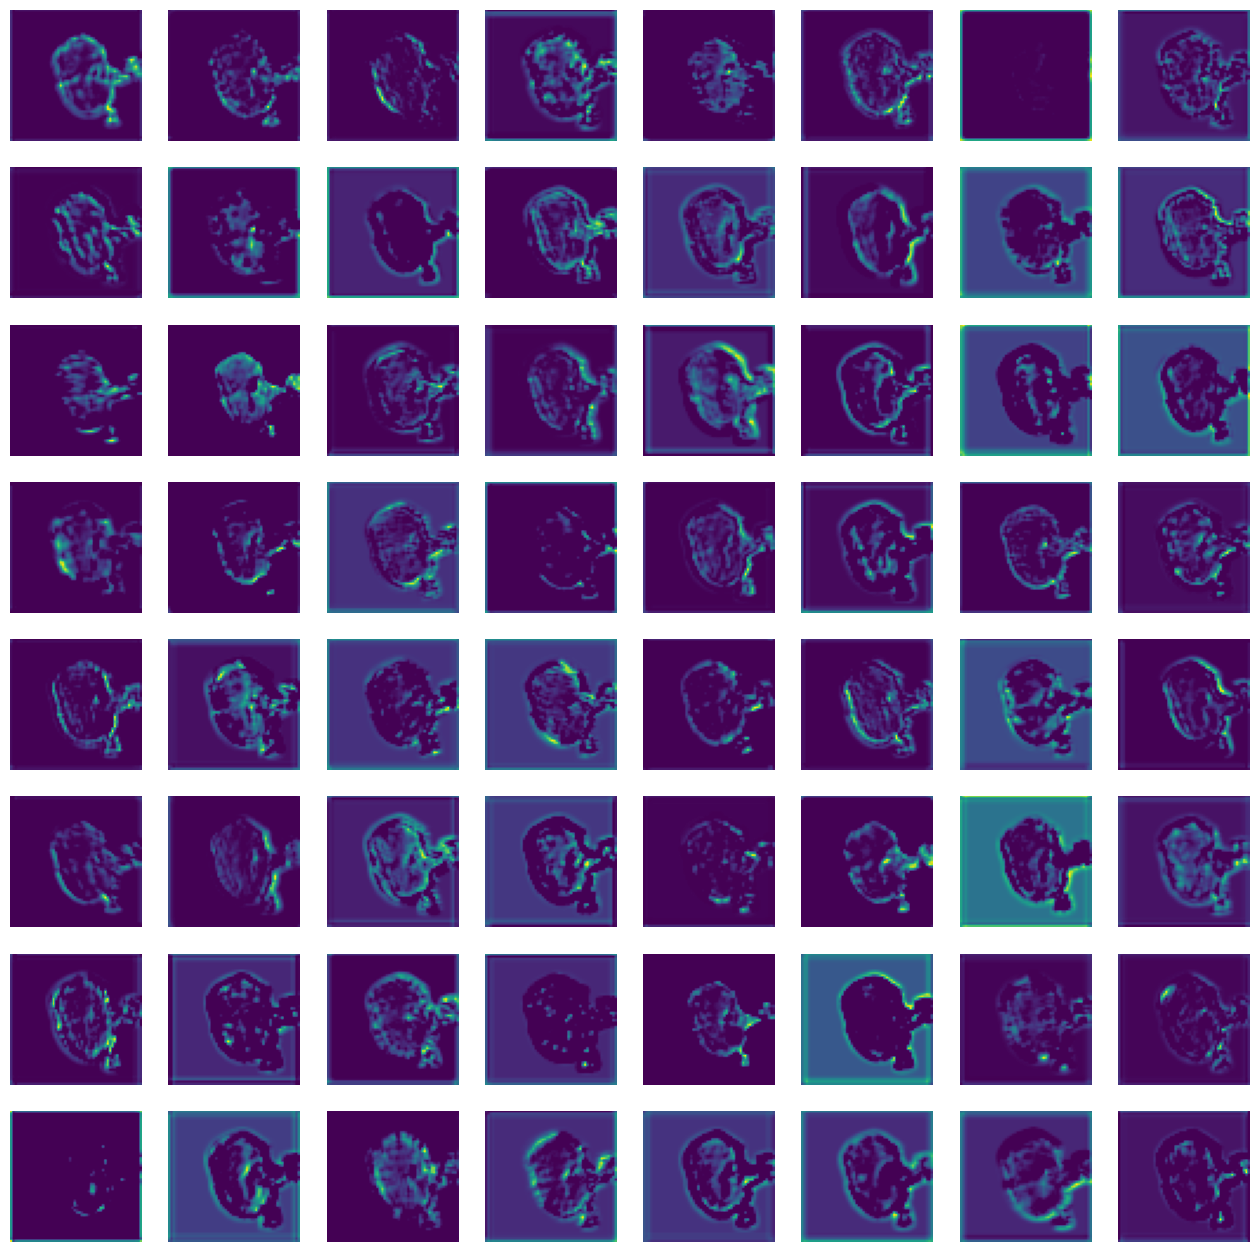

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block3_conv2'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

1/1 [==============================] - 1s 768ms/step


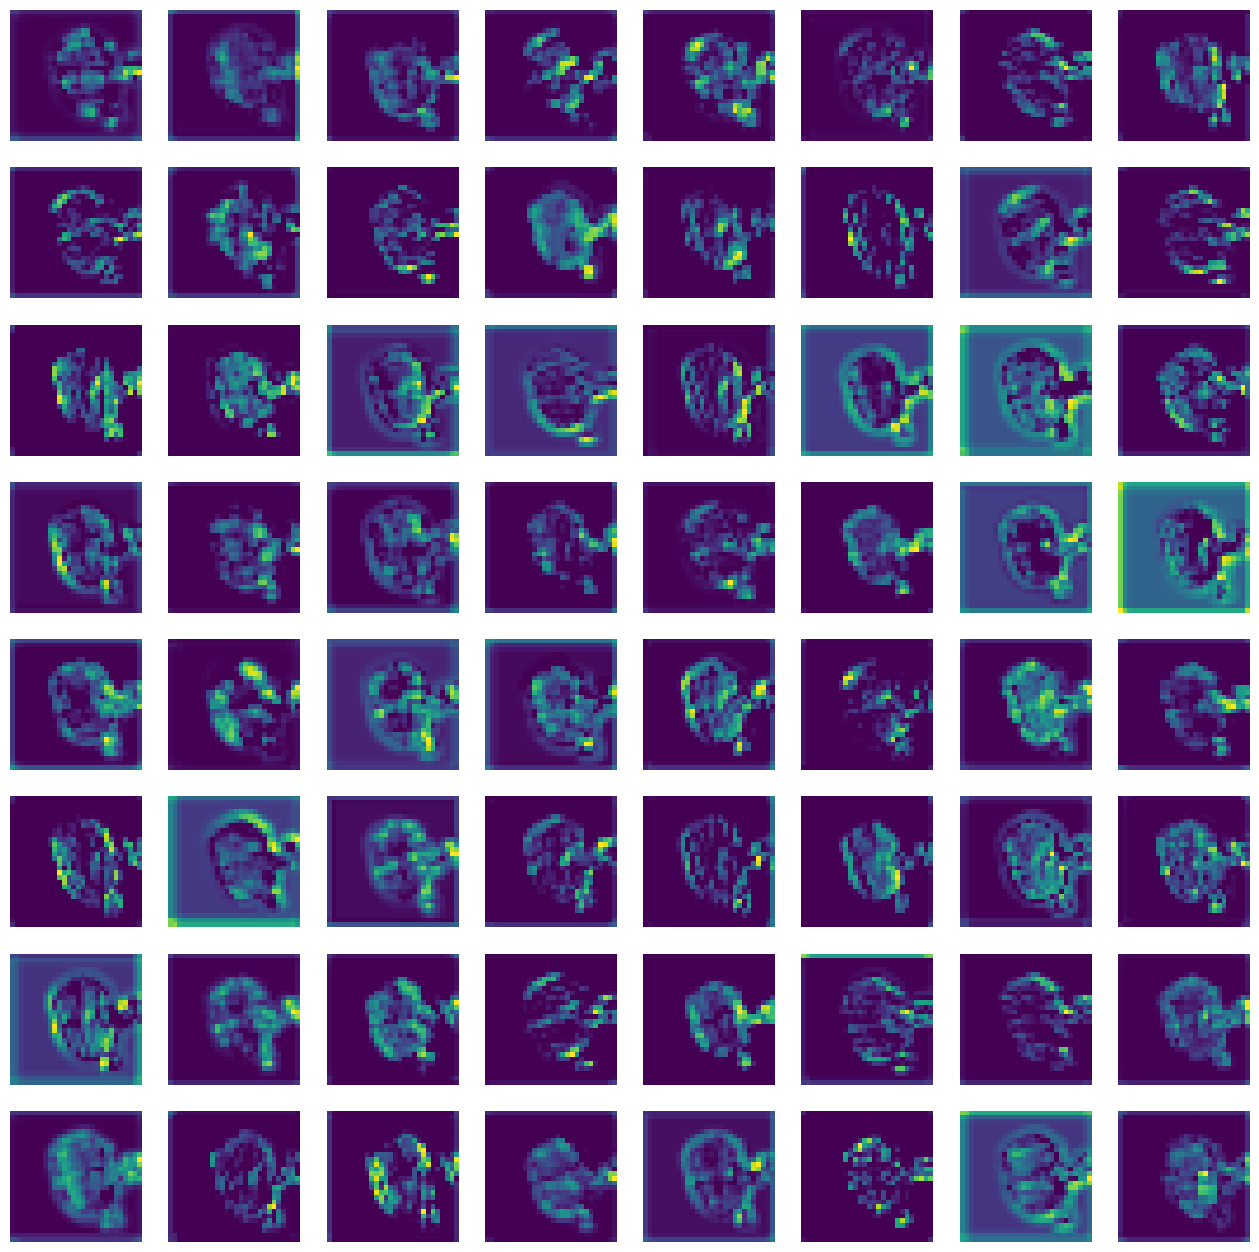

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block3_pool'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

block4

1/1 [==============================] - 1s 565ms/step


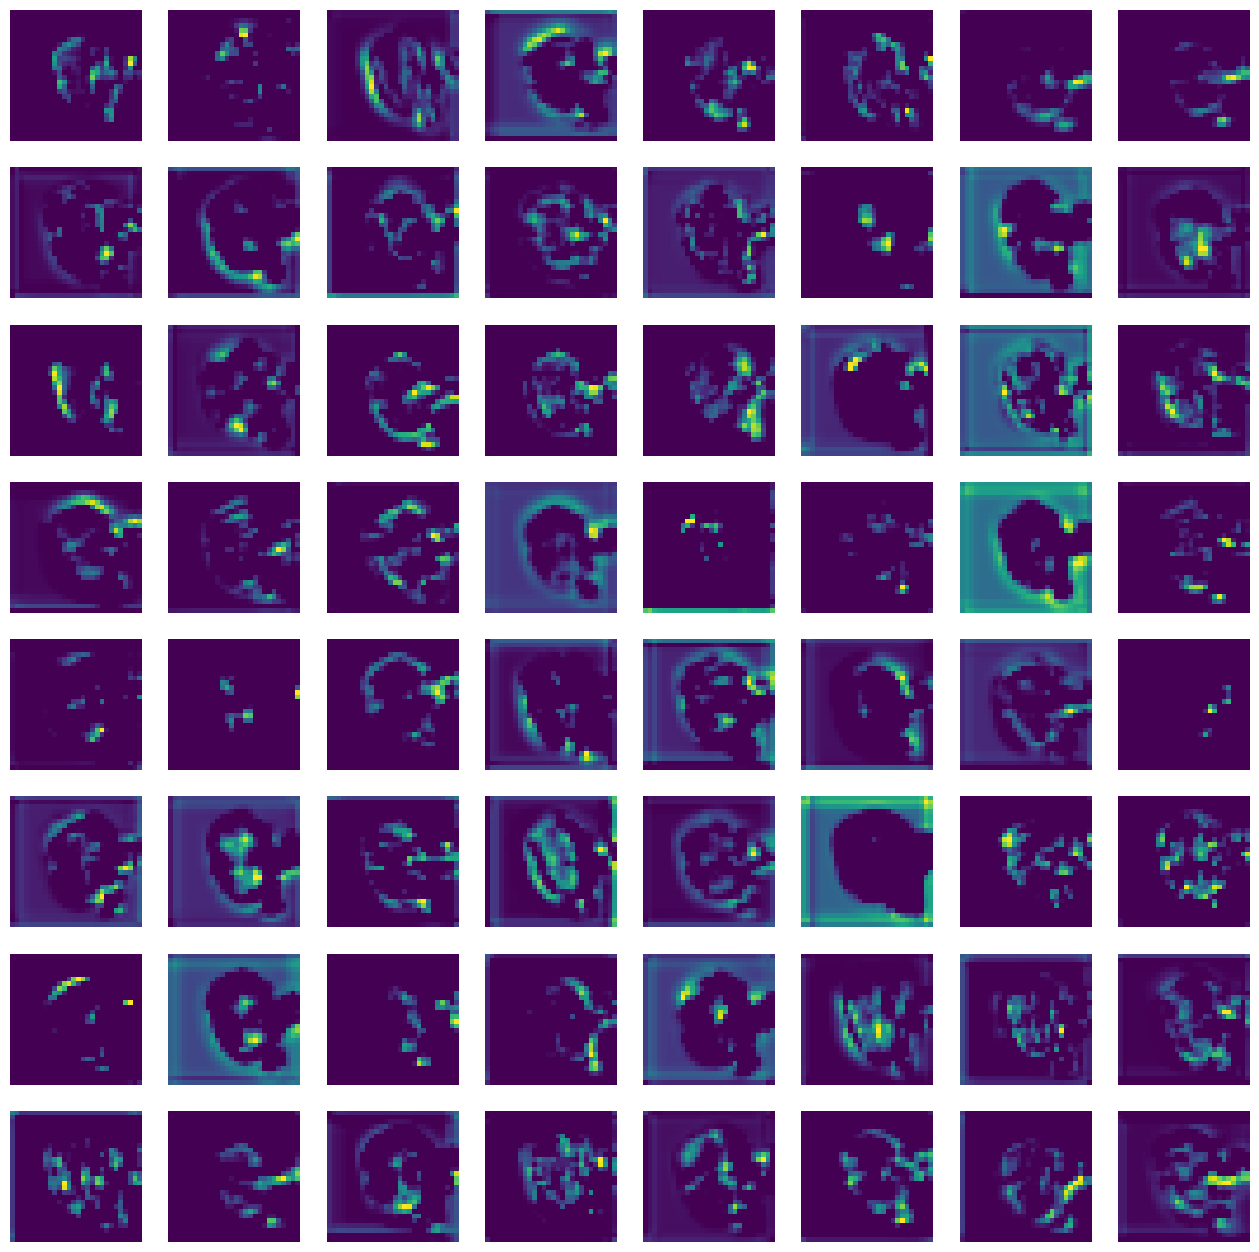

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block4_conv2'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

1/1 [==============================] - 1s 728ms/step


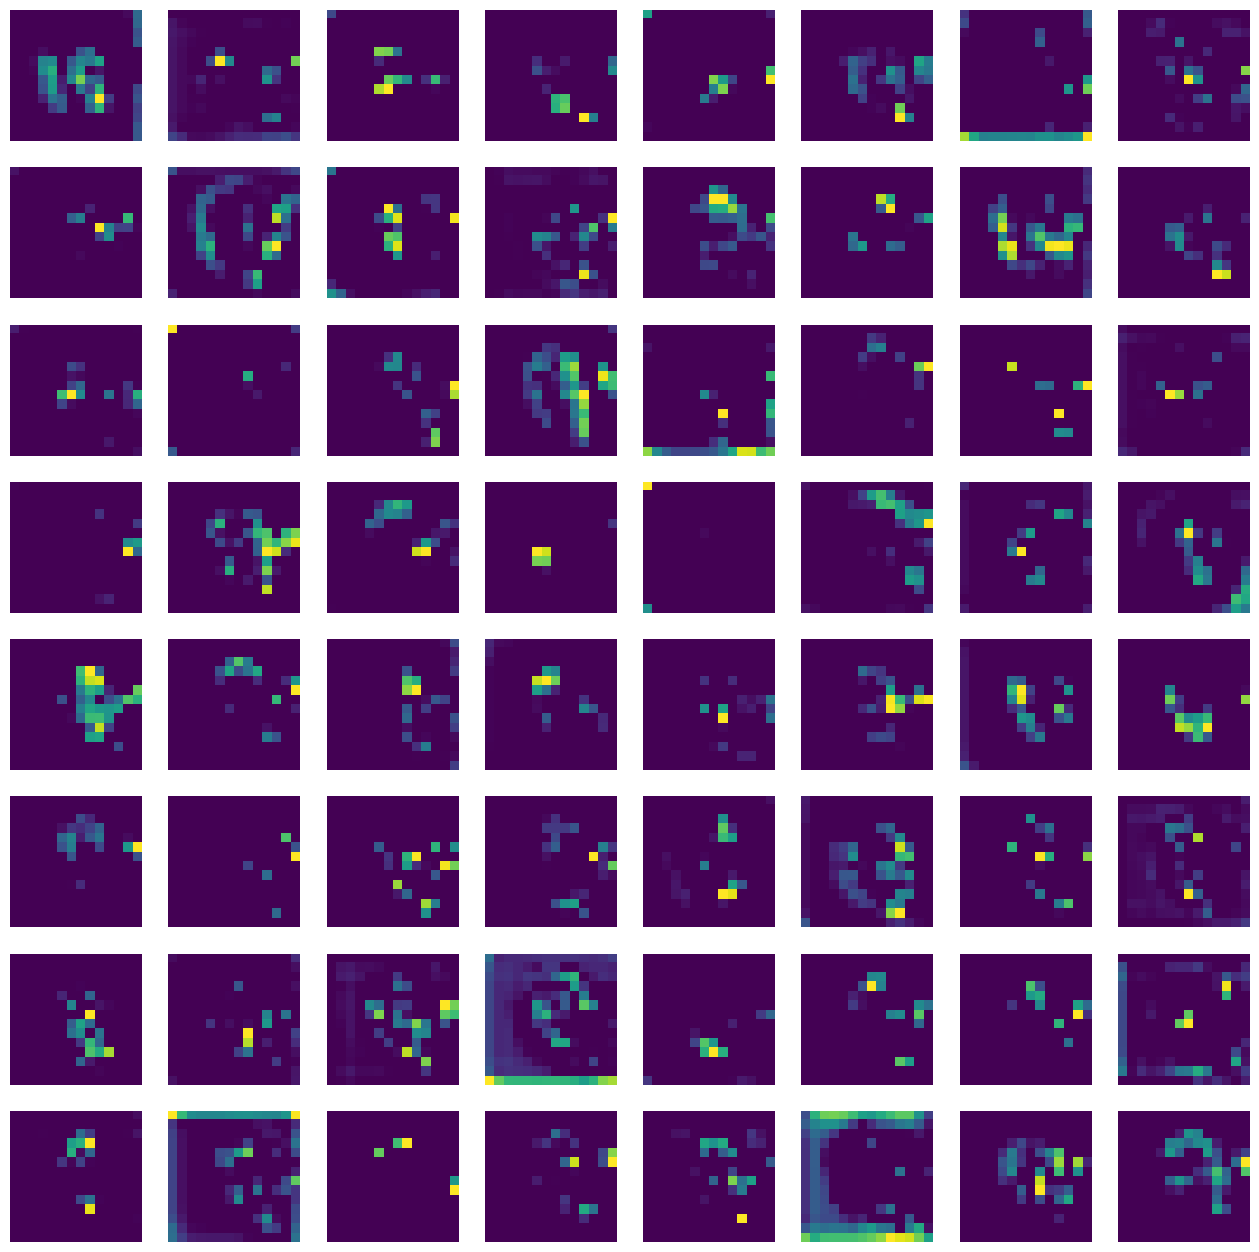

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block4_pool'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

block5

1/1 [==============================] - 1s 1s/step


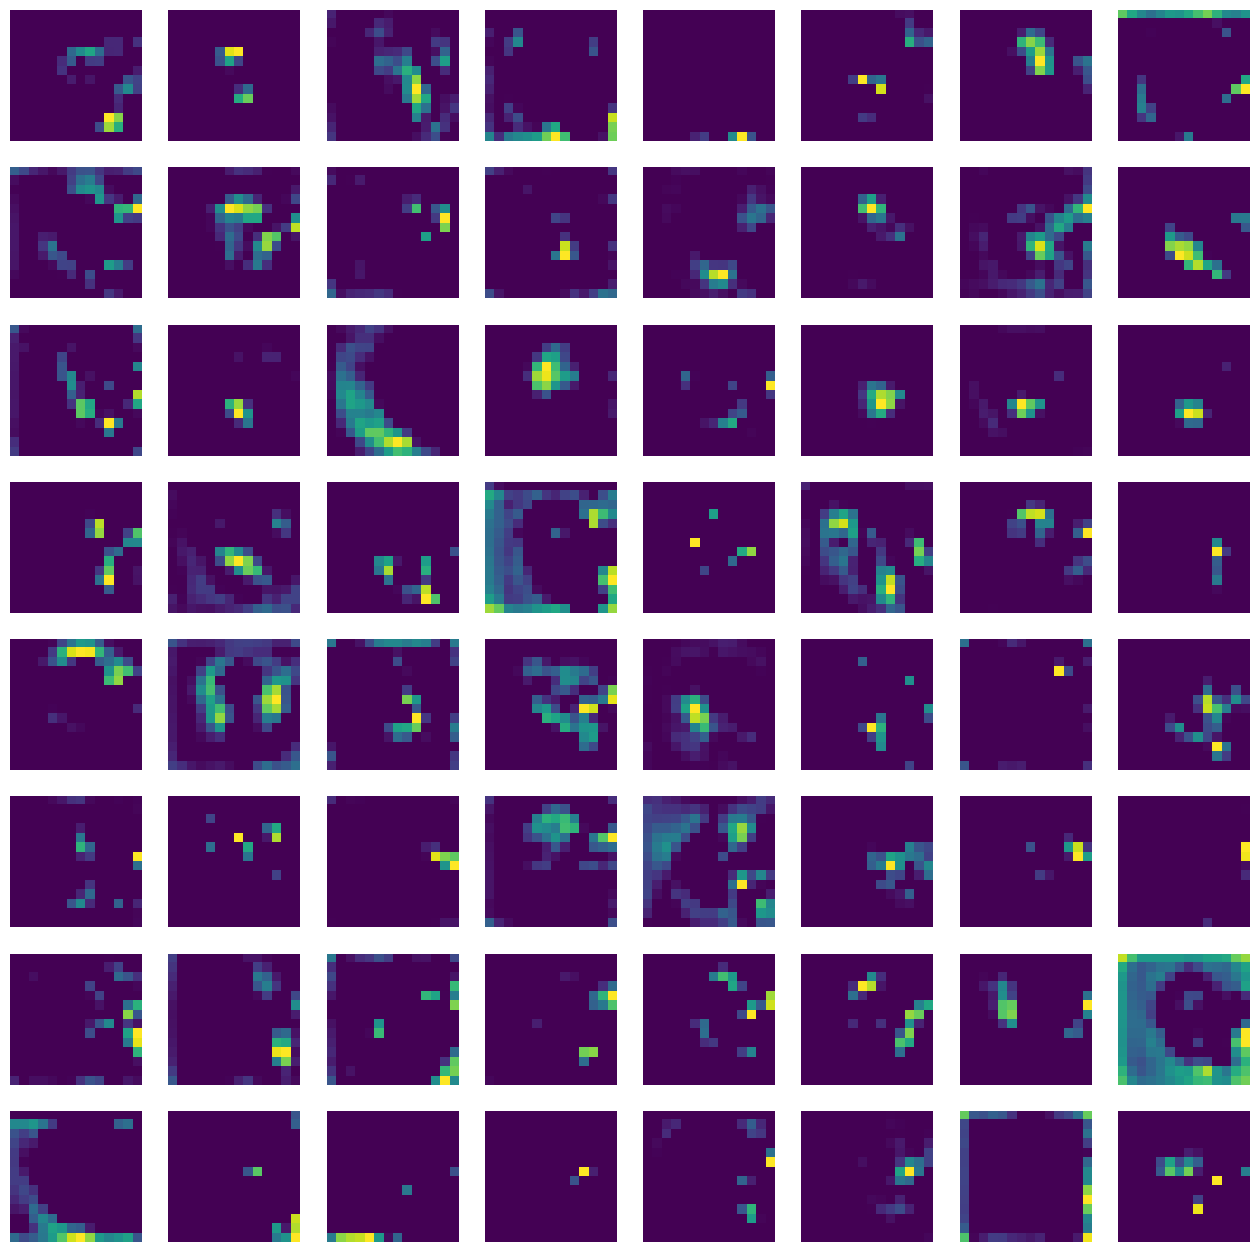

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block5_conv2'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

1/1 [==============================] - 1s 786ms/step


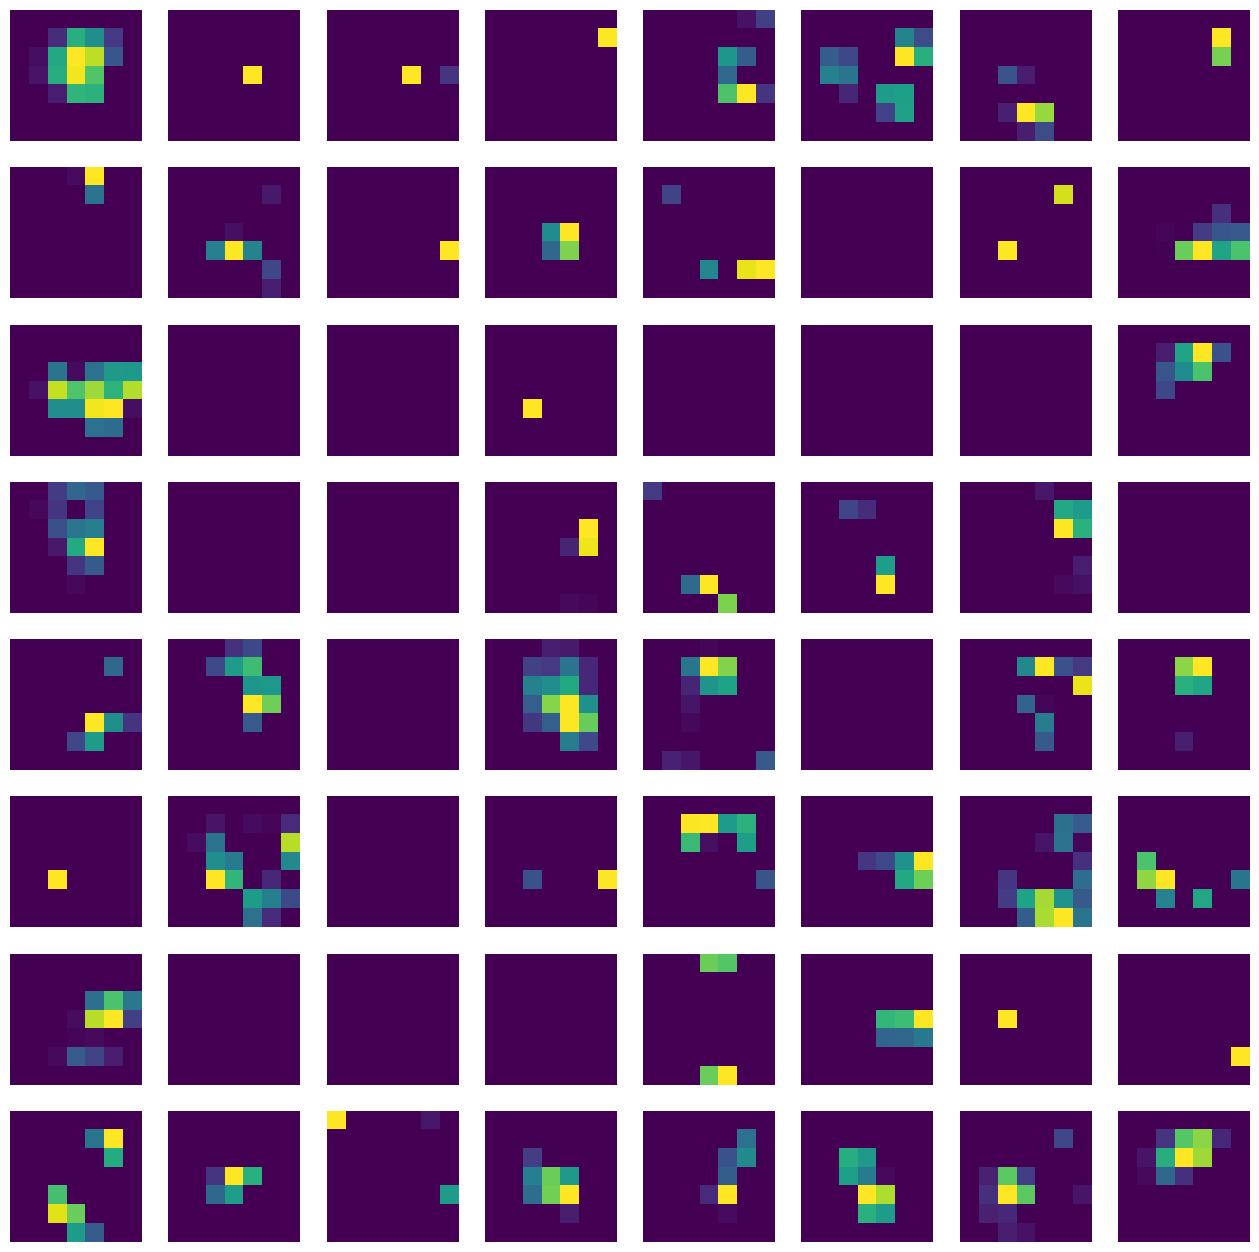

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.vgg16.preprocess_input(image)
image = tf.expand_dims(image, axis=0)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

# Define the layer from which you want to visualize activations
layer_name = 'block5_pool'
layer = model.get_layer(layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

# Get activations for the image
activations = activation_model.predict(image)

# Visualize the activations
plt.figure(figsize=(16, 16))
for i in range(64):  # Visualize the activations of the first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()